In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read data and create train and test text files
import pandas as pd
import re
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/DL/Project/data/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')

def create_text_files(df, dest_path):
    with open(dest_path, 'w') as f:
        data = ''
        for texts in df.iterrows():
            ingredients  = str(texts[1]['Ingredients']).strip()[1:-1]
            instructions = str(texts[1]['Instructions']).strip()

            ingredients = re.sub(r"\s", " ", ingredients)
            instructions = re.sub(r"\s", " ", instructions)

            summary = 'Ingredients: ' + ingredients + '\nInstructions: ' + instructions
            data += summary + "\n"
        f.write(data)

train, test = train_test_split(df,test_size=0.15)

create_text_files(train,'/content/drive/MyDrive/DL/Project/data/train_dataset.txt')
create_text_files(test,'/content/drive/MyDrive/DL/Project/data/test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 11475
Test dataset length: 2026


In [3]:
# load the data into huggingface datasets and create model and tokenizer
from transformers import TextDataset,DataCollatorForLanguageModeling
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_path = '/content/drive/MyDrive/DL/Project/data/train_dataset.txt'
test_path = '/content/drive/MyDrive/DL/Project/data/test_dataset.txt'

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128
)

test_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=test_path,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [4]:
# training step
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/DL/Project/gpt2-recipe",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='/content/drive/MyDrive/DL/Project/logs',
    save_strategy='no',
    eval_strategy="epoch",
    logging_steps=100,
    warmup_steps=200,
    weight_decay=0.01,
    logging_first_step=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

initial_validation = trainer.evaluate()
# trainer.train()
# final_validation = trainer.evaluate()

print(f"Initial validation loss: {initial_validation['eval_loss']}")
# print(f"Final validation loss: {final_validation['eval_loss']}")

Initial validation loss: 2.8516454696655273


In [14]:
# import json
# with open("/content/drive/MyDrive/DL/Project/logs/log_data.json", 'w') as f:
#     json.dump(trainer.state.log_history, f, indent=4)

# print(f"Training logs saved to logs")

Training logs saved to logs


In [5]:
import json

file_path = '/content/drive/MyDrive/DL/Project/logs/log_data.json'
with open(file_path, 'r') as f:
    train_logs = json.load(f)

print(train_logs)

[{'loss': 3.2557, 'grad_norm': 8.869467735290527, 'learning_rate': 2.5000000000000004e-07, 'epoch': 0.0002449179524859172, 'step': 1}, {'loss': 2.9081, 'grad_norm': 6.846681118011475, 'learning_rate': 2.5e-05, 'epoch': 0.02449179524859172, 'step': 100}, {'loss': 2.605, 'grad_norm': 7.053561210632324, 'learning_rate': 5e-05, 'epoch': 0.04898359049718344, 'step': 200}, {'loss': 2.5187, 'grad_norm': 5.487305164337158, 'learning_rate': 4.987693822298794e-05, 'epoch': 0.07347538574577517, 'step': 300}, {'loss': 2.4255, 'grad_norm': 5.6913981437683105, 'learning_rate': 4.975387644597588e-05, 'epoch': 0.09796718099436688, 'step': 400}, {'loss': 2.4077, 'grad_norm': 5.014596462249756, 'learning_rate': 4.9630814668963824e-05, 'epoch': 0.12245897624295861, 'step': 500}, {'loss': 2.3397, 'grad_norm': 4.184401512145996, 'learning_rate': 4.9507752891951764e-05, 'epoch': 0.14695077149155034, 'step': 600}, {'loss': 2.3302, 'grad_norm': 4.293142795562744, 'learning_rate': 4.9384691114939705e-05, 'epoc

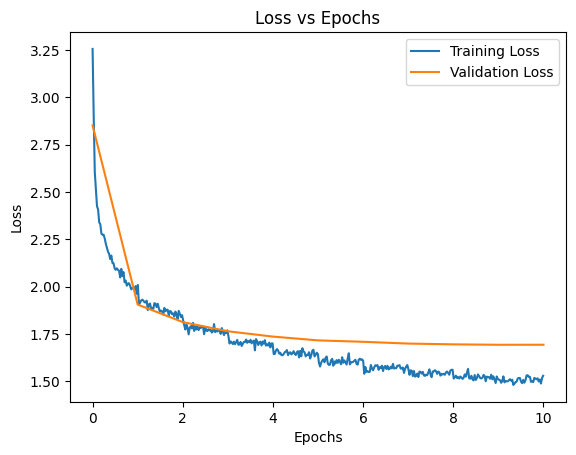

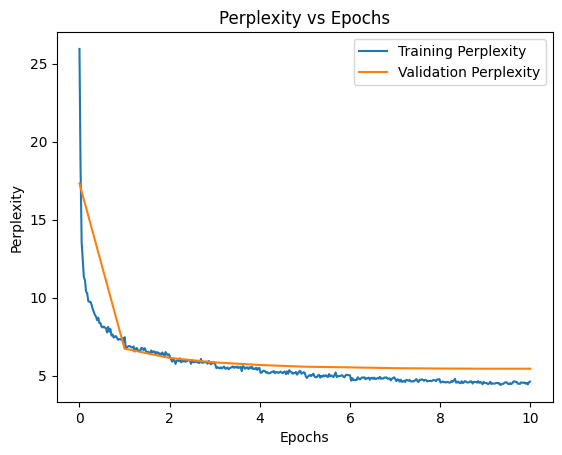

In [6]:
import matplotlib.pyplot as plt
import numpy as np

train_x_axis = []
val_x_axis = []
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

val_x_axis.append(0)
val_losses.append(initial_validation['eval_loss'])
val_perplexities.append(np.exp(initial_validation['eval_loss']))

for log in train_logs:
    if 'eval_loss' in log:
        val_x_axis.append(log['epoch'])
        val_losses.append(log['eval_loss'])
        val_perplexities.append(np.exp(log['eval_loss']))
    elif 'loss' in log:
        train_x_axis.append(log['epoch'])
        train_losses.append(log['loss'])
        train_perplexities.append(np.exp(log['loss']))

fig, ax = plt.subplots()

# Plot Loss
ax.plot(train_x_axis, train_losses, label='Training Loss')
ax.plot(val_x_axis, val_losses, label='Validation Loss')
ax.set_title('Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
fig.show()

fig, ax = plt.subplots()

# Plot Perplexity
ax.plot(train_x_axis, train_perplexities, label='Training Perplexity')
ax.plot(val_x_axis, val_perplexities, label='Validation Perplexity')
ax.set_title('Perplexity vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Perplexity')
ax.legend()
fig.show()
